# Graph embedding using Graph Convolutional Networks (GCN)

In [1]:
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline

### Graph embedding using GCN in stellargraph

Install stellargraph
```python
$pip install stellargraph

In [2]:
import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN
from tensorflow.keras import Model

### Load the Cora dataset

In [3]:
dataset = sg.datasets.Cora()
display(HTML(dataset.description))
graph, node_subjects = dataset.load()

In [4]:
print(graph.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]
        Weights: all 1 (default)
        Features: none


In [5]:
node_subjects.value_counts().to_frame()

,subject
Neural_Networks,818
Probabilistic_Methods,426
Genetic_Algorithms,418
Theory,351
Case_Based,298
Reinforcement_Learning,217
Rule_Learning,180


### Visualize the Cora graph using networkx

Visualization of 50 nodes of Cora graph-structured data

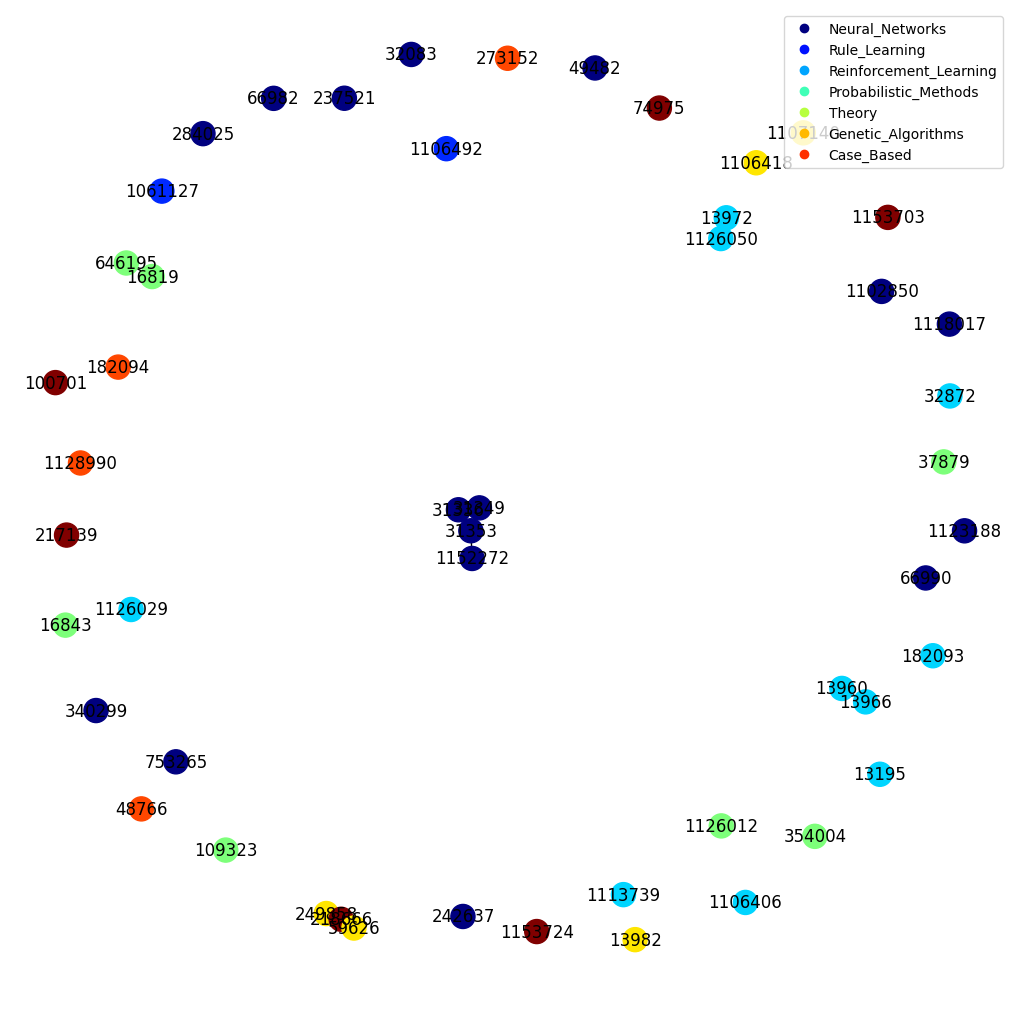

In [6]:
# Convert to NetworkX
Gnx = graph.to_networkx()

# Draw a subgraph with the first 50 nodes for simplicity
node_list = list(Gnx.nodes)[:50]
H = Gnx.subgraph(node_list)

# Create a color map based on the unique subjects
color_map = {str(node): idx for idx, node in enumerate(node_subjects.unique())}

# Get the corresponding colors for the selected nodes based on their subject
node_colors = [color_map[str(node_subjects[node])] for node in H.nodes()]

plt.figure(figsize=(10,10))
nx.draw(H, pos=nx.spring_layout(H, seed=42), with_labels=True, node_color=node_colors, cmap=plt.cm.jet)

# Adding legend
for subject in node_subjects.unique():
    color = plt.cm.jet(color_map[str(subject)] / len(node_subjects.unique()))
    plt.plot([], [], 'o', color=color, label=subject)

plt.legend(loc='upper right')
plt.show()

### Visualizing top 10 nodes with the highest degree of centrality in Cora dataset

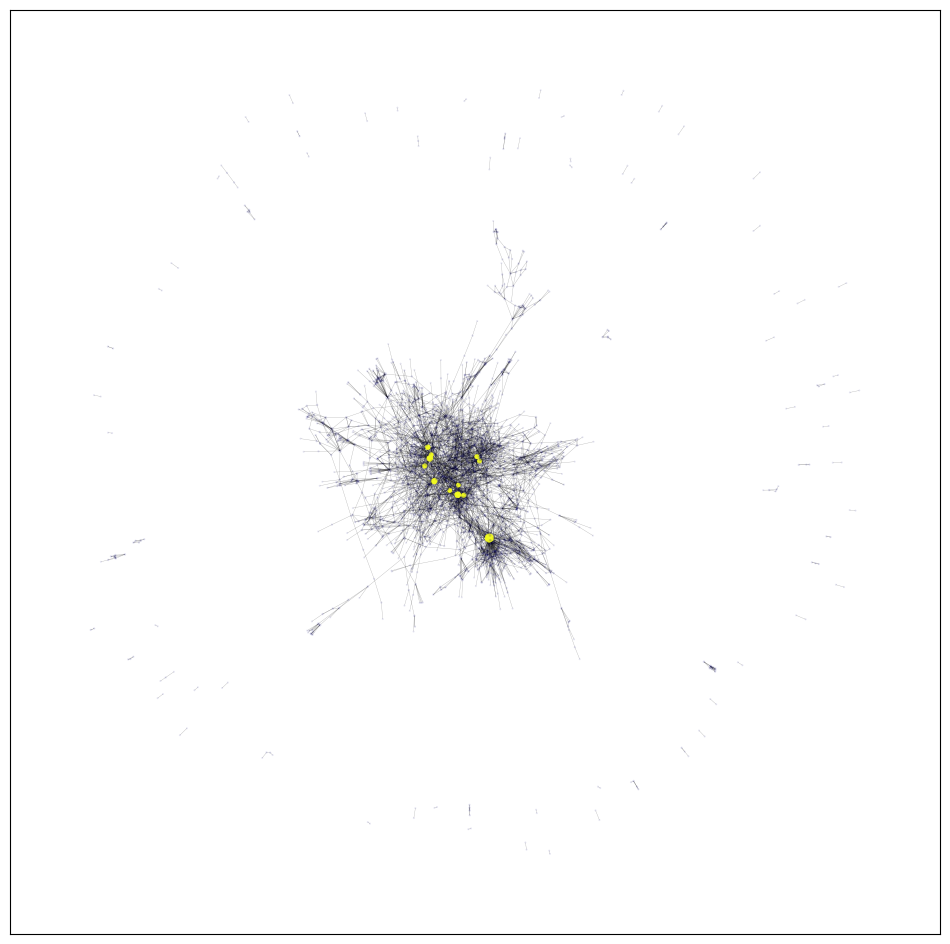

threshold 0.011821204285186553


In [7]:
pos = nx.spring_layout(Gnx, seed=42)
cent = nx.degree_centrality(Gnx)
node_size = list(map(lambda x: x * 500, cent.values()))
cent_array = np.array(list(cent.values()))
threshold = sorted(cent_array, reverse=True)[10]
cent_bin = np.where(cent_array >= threshold, 1, 0.1)
plt.figure(figsize=(12, 12))
nodes = nx.draw_networkx_nodes(Gnx, pos, node_size=node_size,
                               cmap=plt.cm.plasma,
                               node_color=cent_bin,
                               nodelist=list(cent.keys()),
                               alpha=cent_bin)
edges = nx.draw_networkx_edges(Gnx, pos, width=0.25, alpha=0.3)
plt.show()
print("threshold", threshold)

### Graph embedding

In [8]:
generator = FullBatchNodeGenerator(graph, method="gcn")

Using GCN (local pooling) filters...


In [9]:
# Build the model
gcn = GCN(
    layer_sizes=[16, 16], activations=["relu", "relu"], generator=generator, dropout=0.5
)

In [10]:
x_inp, x_out = gcn.in_out_tensors()
x_out

<KerasTensor: shape=(1, None, 16) dtype=float32 (created by layer 'gather_indices')>

In [11]:
# Create a model that generates embeddings
embedding_model = Model(inputs=x_inp, outputs=x_out)

In [12]:
all_gen = generator.flow(node_subjects.index)

In [13]:
emb = embedding_model.predict(all_gen)
emb.shape

1/1 [==============================] - 0s 494ms/step


(1, 2708, 16)

In [14]:
transform = PCA # or TSNE

In [15]:
X = emb.squeeze(0)
X.shape

(2708, 16)

In [16]:
trans = transform(n_components=2)
X_reduced = trans.fit_transform(X)
X_reduced.shape

(2708, 2)

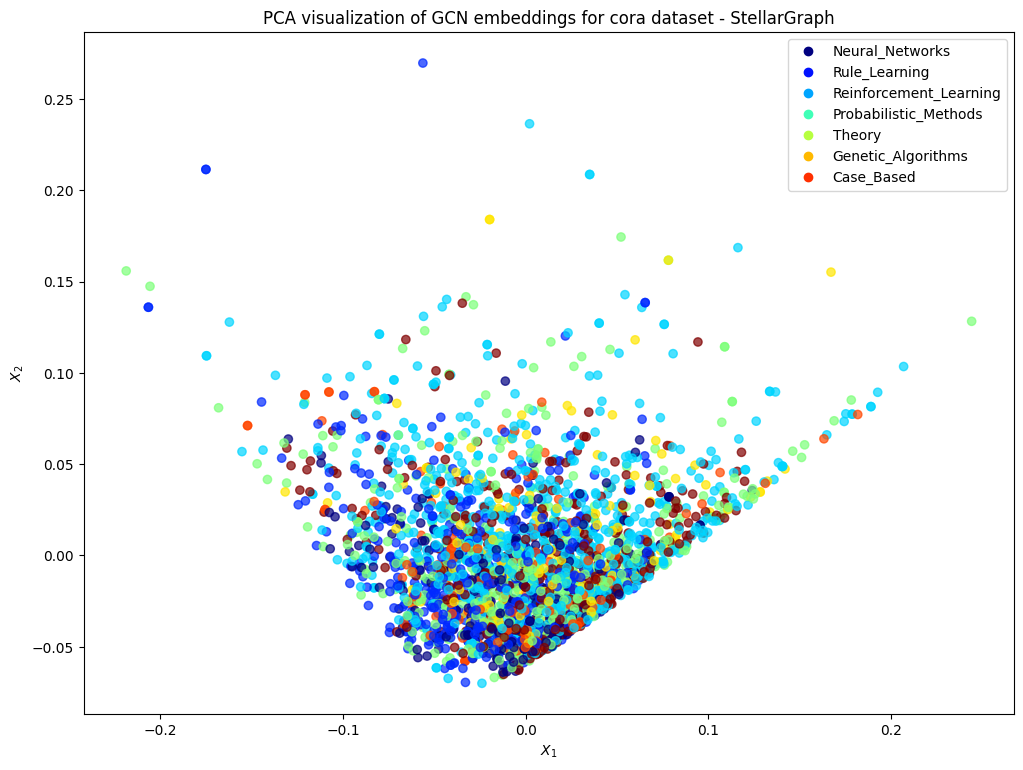

In [17]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    c=node_subjects.astype("category").cat.codes,
    cmap="jet",
    alpha=0.7,
)
ax.set(
    aspect="equal",
    xlabel="$X_1$",
    ylabel="$X_2$",
    title=f"{transform.__name__} visualization of GCN embeddings for cora dataset - StellarGraph",
)

# Adding legend
for subject in node_subjects.unique():
    color = plt.cm.jet(color_map[str(subject)] / len(node_subjects.unique()))
    plt.plot([], [], 'o', color=color, label=subject)

plt.legend(loc='upper right')
plt.show()

# Graph embedding using PyG (PyTorch Geometric)

Follow these steps to install touch_geometric and its dependencies

```python
$conda create -n gml python=3.7
$conda activate gml
$conda install pytorch torchvision -c pytorch
$conda install torch_scatter
$conda install torch_sparse
$conda install torch_cluster
$conda install torch-spline-conv
$conda install tourch_geometric
$conda install osmnx

In [18]:
import torch
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv

In [19]:
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

In [20]:
# Load the Cora dataset
dataset = Planetoid(root='/tmp/Cora', name='Cora')

class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)
        self.dropout = torch.nn.Dropout(0.5)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)

        return x

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = torch.nn.functional.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

model.eval()
final_embeddings = model(data).detach().cpu().numpy()

print("Final Embeddings: ", final_embeddings)

Final Embeddings:  [[1948.6392 1968.195  1937.845  ... 2014.1593 1937.8573 1905.8463]
 [2959.3389 2987.4731 2941.5059 ... 3059.8694 2941.8137 2893.1948]
 [3015.497  3044.8896 2998.015  ... 3117.8435 2997.8467 2948.4473]
 ...
 [1590.3992 1605.1484 1580.6562 ... 1643.2635 1581.4519 1555.2335]
 [2133.0776 2154.0972 2120.8591 ... 2204.984  2120.984  2086.0154]
 [2007.9147 2027.8297 1996.5944 ... 2075.6416 1996.5372 1963.7645]]


In [22]:
final_embeddings.shape

(2708, 7)

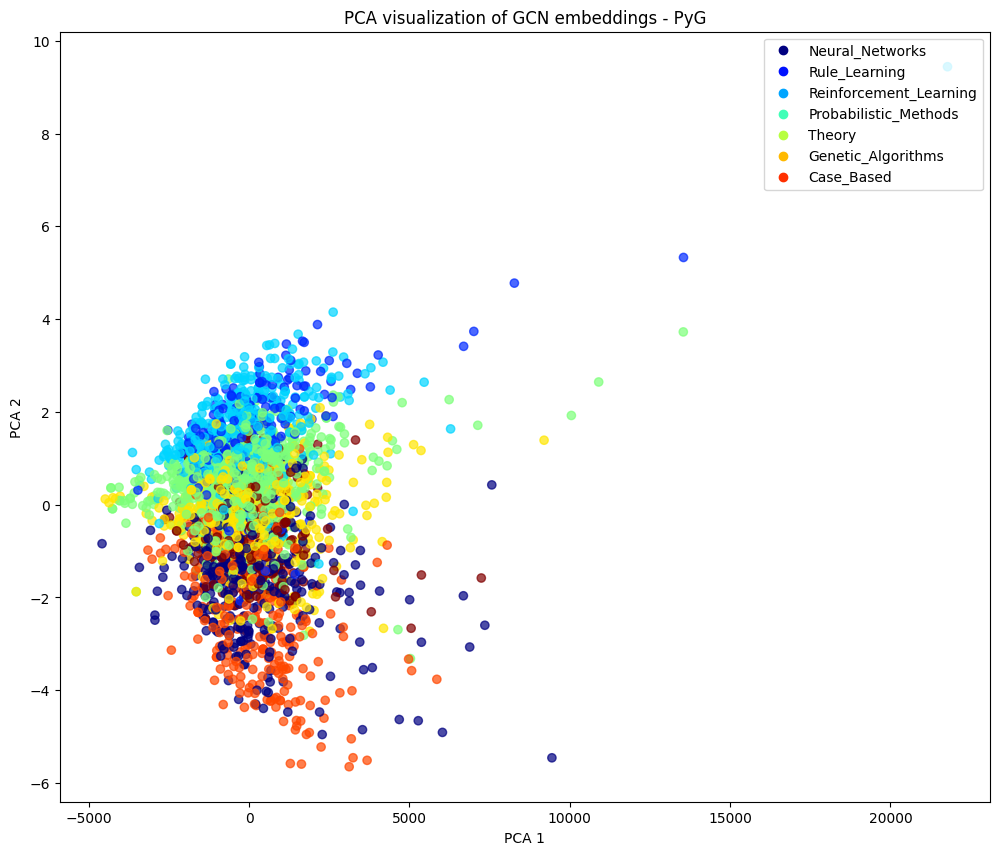

In [23]:
# Compute t-SNE embeddings of the GCN embeddings
pca = PCA(n_components=2)
node_embeddings_2d = pca.fit_transform(final_embeddings)

# Get the class labels for each node
labels = data.y.cpu().numpy()

# Create a scatter plot of the 2-dimensional t-SNE embeddings
plt.figure(figsize=(12, 10))
plt.scatter(node_embeddings_2d[:, 0], node_embeddings_2d[:, 1], c=labels, cmap='jet', alpha=0.7)

# Adding legend
for subject in node_subjects.unique():
    color = plt.cm.jet(color_map[str(subject)] / len(node_subjects.unique()))
    plt.plot([], [], 'o', color=color, label=subject)

plt.legend(loc='upper right')

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA visualization of GCN embeddings - PyG')
plt.show()